# EDA Dataset Walmart

Walmart Inc. (formerly Wal-Mart Stores, Inc.) is an American multinational retail corporation that operates a chain of hypermarkets (also called supercenters), discount department stores, and grocery stores in the United States and 23 other countries. It is headquartered in Bentonville, Arkansas. The company was founded by brothers Sam and James "Bud" Walton in nearby Rogers, Arkansas in 1962 and incorporated under Delaware General Corporation Law on October 31, 1969. It also owns and operates Sam's Club retail warehouses. [1](https://en.wikipedia.org/wiki/Walmart)


En esta sección se elabora un Análisis exploratorio sobre el dataset de [Walmart](https://www.kaggle.com/datasets/varsharam/walmart-sales-dataset-of-45stores) alojado en Kaggle

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
#import plotly.express as px
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro


## Estadísticas Descriptivas

Primeramente obtenemos las estadísticas basicas del dataset así:

In [3]:
df = pd.read_csv("../datasets/walmart-sales-dataset-of-45stores.csv", sep=",")

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

descriptives = df.iloc[:, 2:].describe()
print(descriptives)


       Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price          CPI  \
count  6.435000e+03   6435.000000  6435.000000  6435.000000  6435.000000   
mean   1.046965e+06      0.069930    60.663782     3.358607   171.578394   
std    5.643666e+05      0.255049    18.444933     0.459020    39.356712   
min    2.099862e+05      0.000000    -2.060000     2.472000   126.064000   
25%    5.533501e+05      0.000000    47.460000     2.933000   131.735000   
50%    9.607460e+05      0.000000    62.670000     3.445000   182.616521   
75%    1.420159e+06      0.000000    74.940000     3.735000   212.743293   
max    3.818686e+06      1.000000   100.140000     4.468000   227.232807   

       Unemployment  
count   6435.000000  
mean       7.999151  
std        1.875885  
min        3.879000  
25%        6.891000  
50%        7.874000  
75%        8.622000  
max       14.313000  


* **_Temperature_**: La temperatura media fue de apoximadamente 60 °F con una desviación relativamente grande de 18.4 grados, se observa tambíen que aproximadamente el 50% de los datos se encuentran por debajo de este promedio. Se evidencia tambien temperaturas extremas de -2 y 100 grados.

* **_Fuel_Price_**: presenta un promedio de 3.35 con una desviación estandar de 0.45, aproximadamente el 50% de los datos se encuentran por debajo del promedio, presenta un dato mínimo y máximo de 2,47 y 4,46 respectivamente, evidenciadose fluctuaciones en estos precios.

* **_CPI_**: Presenta una media y desviación estandar de 171.57 y 39.35 respectivamente, con un dato mínimo y máximo de 126 y 227, tanto el **_CPI_** como el **_Unemployment_** presentan comportamiento similares a las otras variables antes descritas.

Podemos obtener información sobre el tipo de datos de las variables y contenido no nulo de las mismas así:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


Se evidencia que no hay datos nulos en el dataset.

Así mismo podemos obtener la forma de dataset:

In [5]:
df.shape

(6435, 8)

El dataset contiene 6435 filas con 8 columnas

Finalmente validamos si hay datos faltantes

In [6]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

El dataset no contiene datos faltantes.

## Otras medidas

Podemos obtener otras medidas de interes como por ejemplo la tienda con mayores ventas y la tienda con mayor variación en las mismas así:

In [7]:
store_sales_df = df.groupby(['Store'], as_index=False).agg(Sum_of_Weekly_Sales=('Weekly_Sales','sum'))
max_storesales = store_sales_df[(store_sales_df['Sum_of_Weekly_Sales'] == max(store_sales_df['Sum_of_Weekly_Sales']))]
print(max_storesales)


    Store  Sum_of_Weekly_Sales
19     20         3.013978e+08


In [8]:
std_stores = df.groupby('Store', as_index=False).agg(Std_of_Weekly_Sales=('Weekly_Sales','std'))
std_sales = std_stores[(std_stores['Std_of_Weekly_Sales'] == max(std_stores['Std_of_Weekly_Sales']))]
print(std_sales)

    Store  Std_of_Weekly_Sales
13     14        317569.949476


## Prueba de Normalidad - Shapiro Wilk

Podemos realizar la prueba para validar si los datos siguen una distribución normal, esta prueba evalúa la siguiente prueba de hipótesis
$$
Ho: \text{La variable presenta una distribución normal}\\
H1: \text{La variable presenta una distribución No normal}
$$

In [9]:
print('Shapiro-Wilk Test:')
stat, p = shapiro(df["Weekly_Sales"])
print('Statistics=%.6f, p=%e' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')

Shapiro-Wilk Test:
Statistics=0.947068, p=3.811532e-43
Sample does not look Normal (reject H0)


Con un **_valor p_** menor a $\alpha = 0.05$ podemos afirmar que no existe suficiente evidencia estadística para sugerir que los datos siguen una distribución normal.

Estos lo podemos evidenciar graficamente a través de un QQ-plot así:

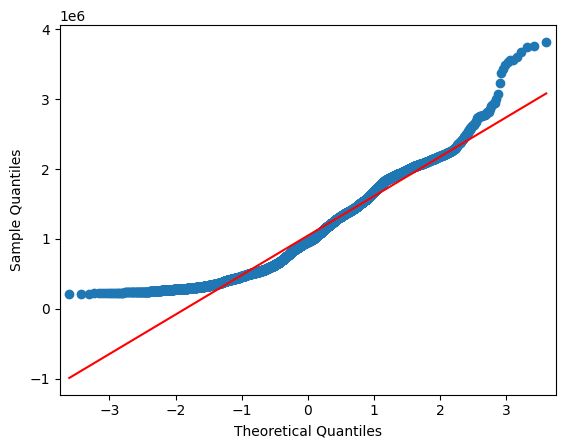

In [10]:
qqplot(df["Weekly_Sales"], line='s');

Podemos evidenciar que los datos no siguen la linea, esto apoya la hipótesis de que el comportamiento no sigue una distribución normal, en este caso se presentan desviaciones en las colas de la distribución, sugiriendonos que pueden haber valores atípicos o estar ante una distribución con alta varianza en los extremos.

## Gráficos de Comportamientos

Podemos graficar el comportamiento de las variables a lo largo del tiempo, para evidenciar posibles comportamientos, tendencias o ciclos durante periodos de tiempo especificos.

### Weekly Sales


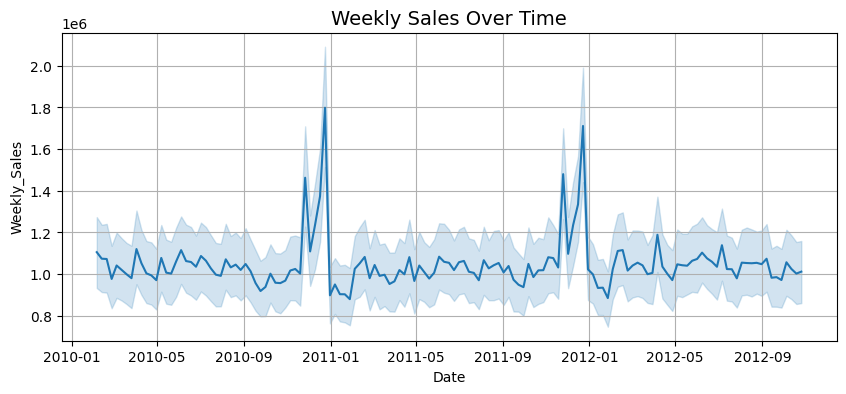

In [11]:
plt.figure(figsize=(10, 4))
plt.title('Weekly Sales Over Time', fontsize=14)
sns.lineplot(data=df, x="Date", y="Weekly_Sales")
plt.grid()

El comportamiento de las ventas semanales durante los años 2010 a 2012 de las tiendas Walmart parecen tener un comportamiento consistente a lo largo del tiempo, se observan breves picos en la temporada de final de año que muy seguramente estan realacionados con eventos como el día de acción de gracias o la navidad. En estos picos evidenciamos tambien que la incertidumbre es mayor con respecto a los otros periodos del año.

Podemos graficar los promedios de ventas mensuales así:

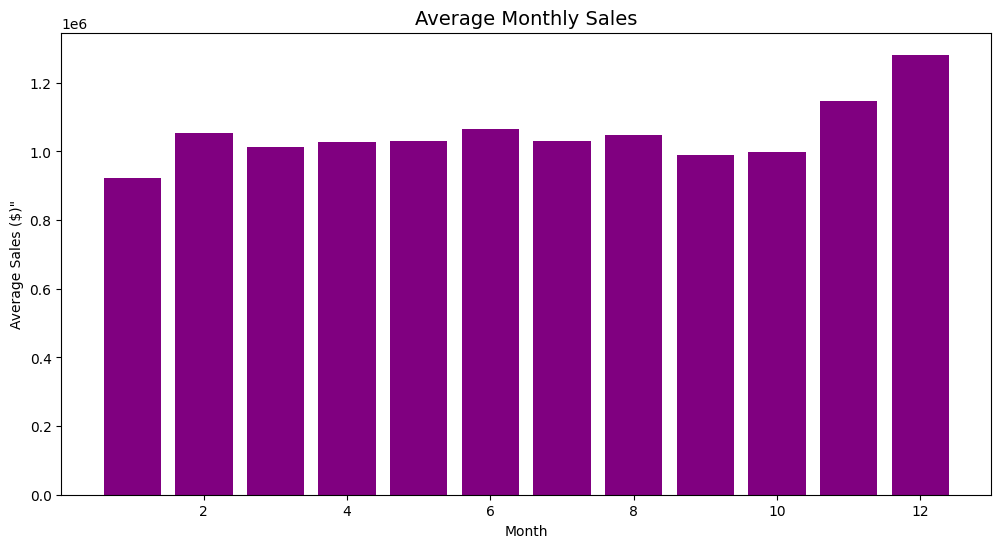

In [12]:
df['Month'] = df['Date'].dt.month

monthly_sales = df.groupby('Month').agg({'Weekly_Sales': 'mean'}).reset_index()

plt.figure(figsize=(12, 6))
plt.bar(monthly_sales['Month'], monthly_sales['Weekly_Sales'], color='purple')
plt.title('Average Monthly Sales', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Average Sales ($)"')
plt.show()


Se observa que el comportamiento es consistente en los meses de enero a septiembre, mientras que de octubre a diciembre se evidencia una tendencia creciente.

También podemos observar el comportamiento por año así:

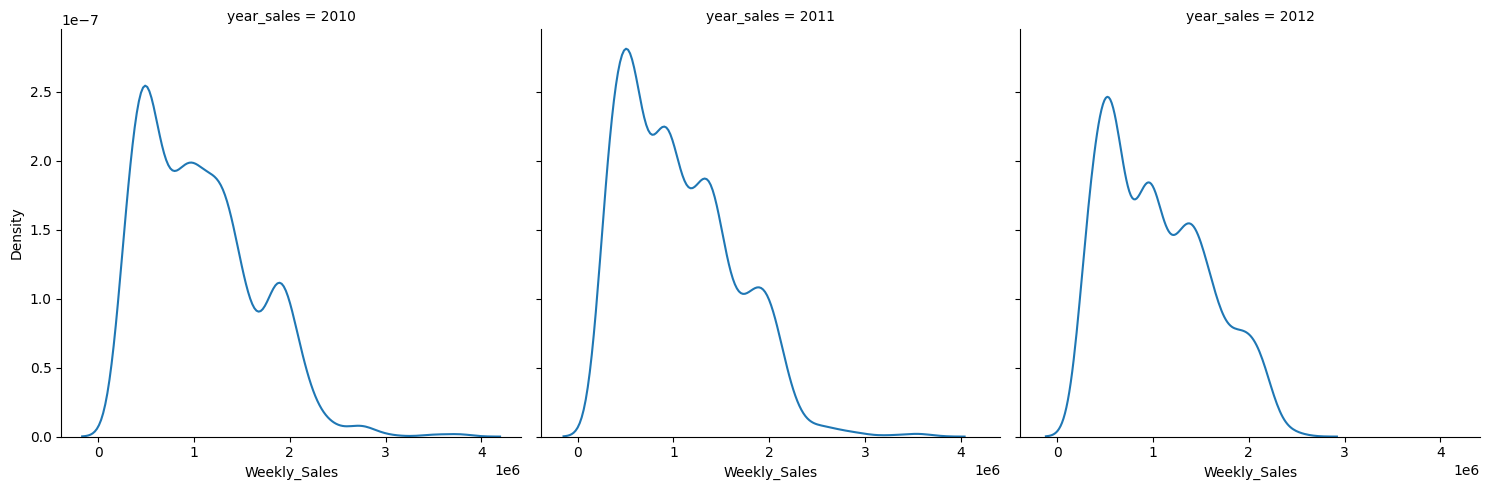

In [13]:
df['year_sales'] = df['Date'].dt.year 
df['year_sales'].value_counts()

sns.displot(data=df, x="Weekly_Sales", col="year_sales", kind="kde")
plt.show()

El comportamiento de las ventas en los diferentes años es similar, en todos los casos las ventas se agrupan mayormente en las primeras semanas, esto lo podemos evidenciar mejor en el siguiente gráfico

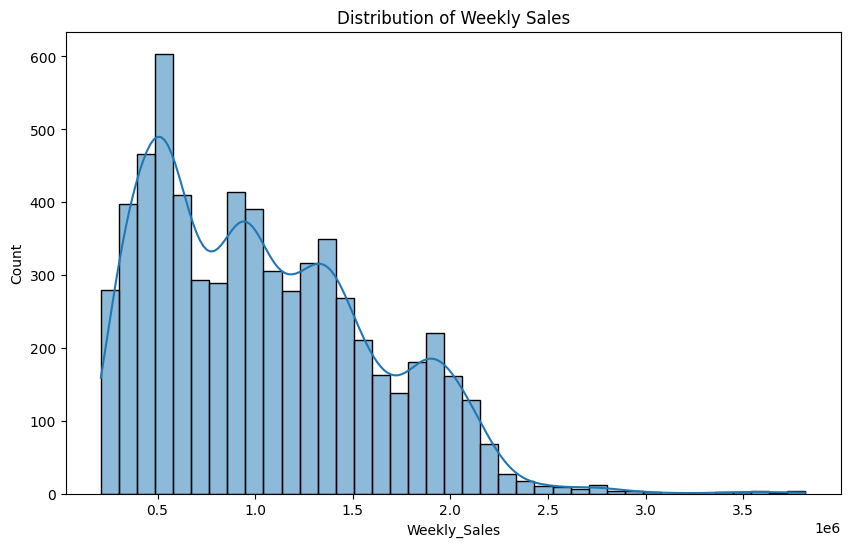

In [14]:
# Plot for 'Weekly_Sales'
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], kde=True)
plt.title('Distribution of Weekly Sales')
plt.show()

### Holiday Flags

Asimismo, podemos observar que la distribución de los días festivos es bastante limitada, ya que estos son en su mayoría minoritarios

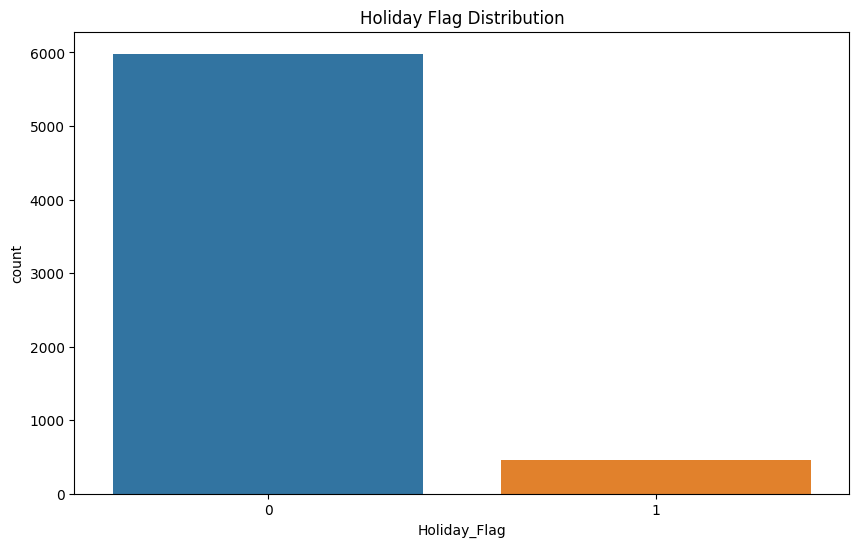

In [15]:
# Plot for 'Holiday_Flag'
plt.figure(figsize=(10, 6))
sns.countplot(x='Holiday_Flag', data=df)
plt.title('Holiday Flag Distribution')
plt.show()

Podemos graficar la variación entre las ventas cuando hay festivos y cuando no los hay así:

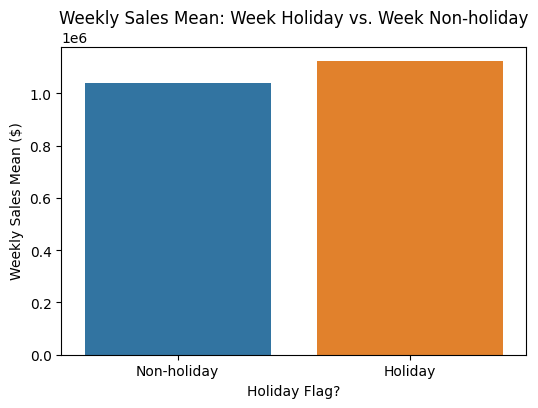

Las ventas durante semanas festivas son un 7.84% más altas en promedio.


In [16]:
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=holiday_sales.index, y=holiday_sales.values)
plt.title('Weekly Sales Mean: Week Holiday vs. Week Non-holiday')
plt.xlabel('Holiday Flag?')
plt.ylabel('Weekly Sales Mean ($)')
plt.xticks([0, 1], ['Non-holiday', 'Holiday'], rotation=0)
plt.show()

holiday_diff = ((holiday_sales[1] - holiday_sales[0]) / holiday_sales[0]) * 100
print(f'Las ventas durante semanas festivas son un {holiday_diff:.2f}% más altas en promedio.')

### Temperature

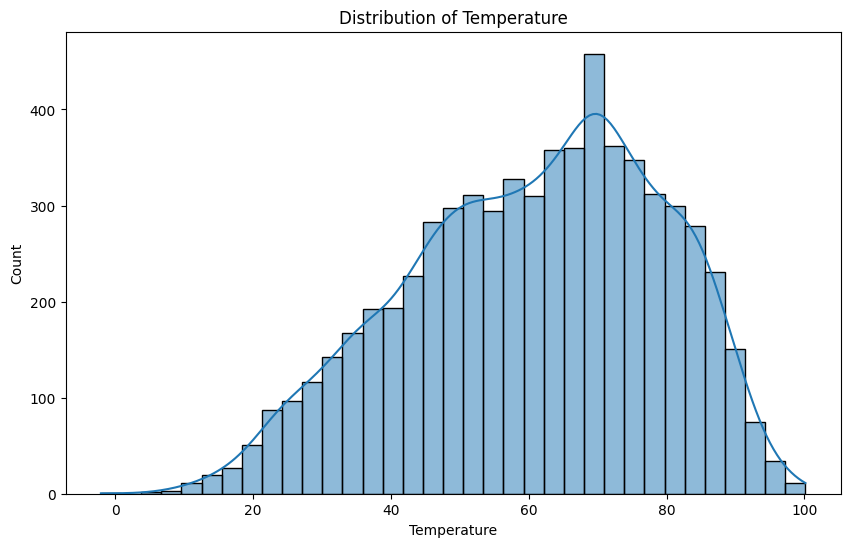

In [17]:
# Plot for 'Temperature'
plt.figure(figsize=(10, 6))
sns.histplot(df['Temperature'], kde=True)
plt.title('Distribution of Temperature')
plt.show()

Observamos gráficamente el mismo comportamiento descrito al inicio del documento, adicionalmente podemos evidenciar una ligera asimetría hacia la derecha, con una cola izquerda mas alargada.

Podemos graficar l relación entre esta variable y las ventas semanales así:

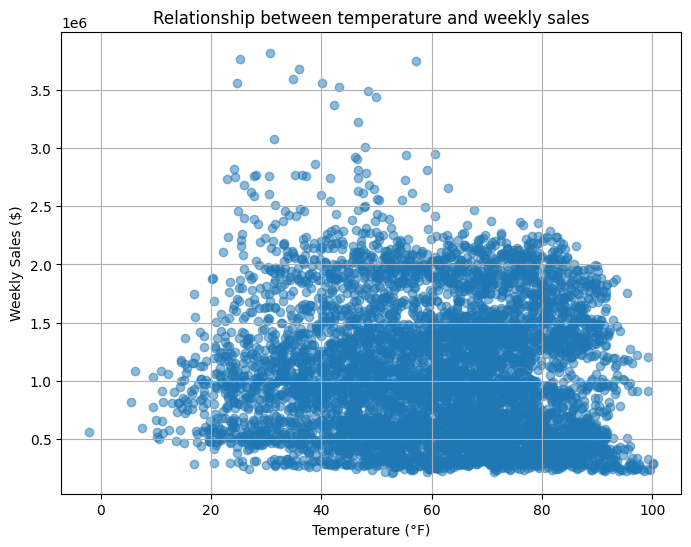

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Temperature'], df['Weekly_Sales'], alpha=0.5)
plt.title('Relationship between temperature and weekly sales')
plt.xlabel('Temperature (°F)')
plt.ylabel('Weekly Sales ($)')
plt.grid(True)
plt.show()

No se observa una relación lineal a simple vista entre estas dos variables.

### Fuel Price

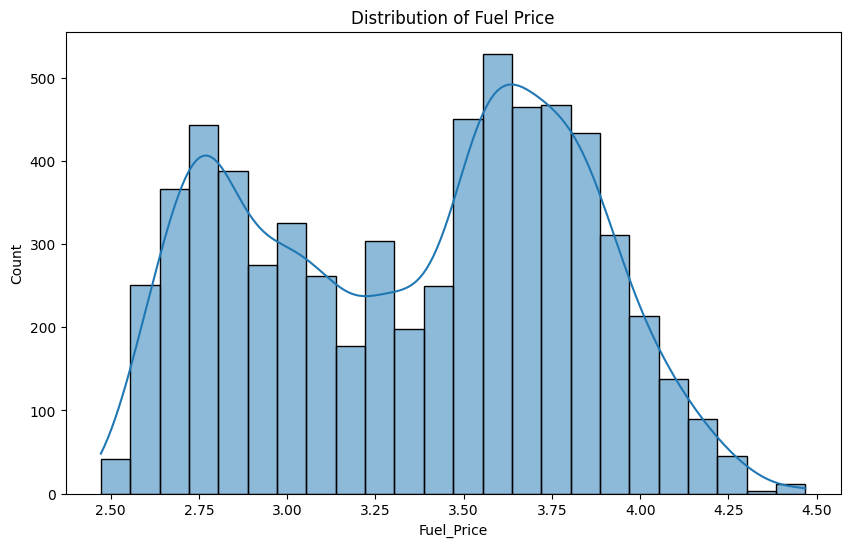

In [19]:
# Plot for 'Fuel_Price'
plt.figure(figsize=(10, 6))
sns.histplot(df['Fuel_Price'], kde=True)
plt.title('Distribution of Fuel Price')
plt.show()

Para el caso de **_Fuel Price_** evidenciamos una distribución bimodal, con un muy pequeño sesgo hacia la derecha.

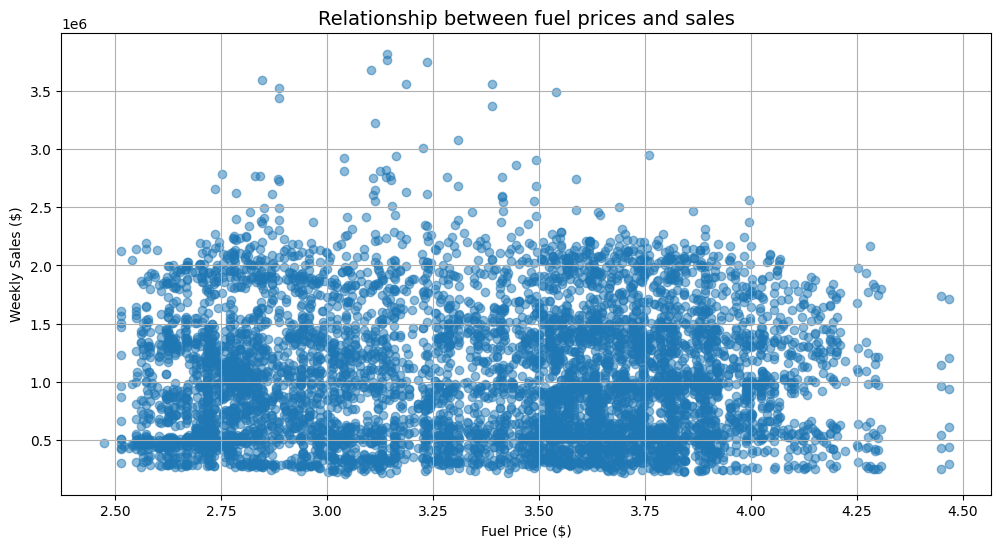

In [20]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Fuel_Price'], df['Weekly_Sales'], alpha=0.5)
plt.title('Relationship between fuel prices and sales', fontsize=14)
plt.xlabel('Fuel Price ($)')
plt.ylabel('Weekly Sales ($)')
plt.grid(True)
plt.show()

Nuevamente no se logra apreciar una relación clara entre esta variable y las ventas semanales.

### CPI

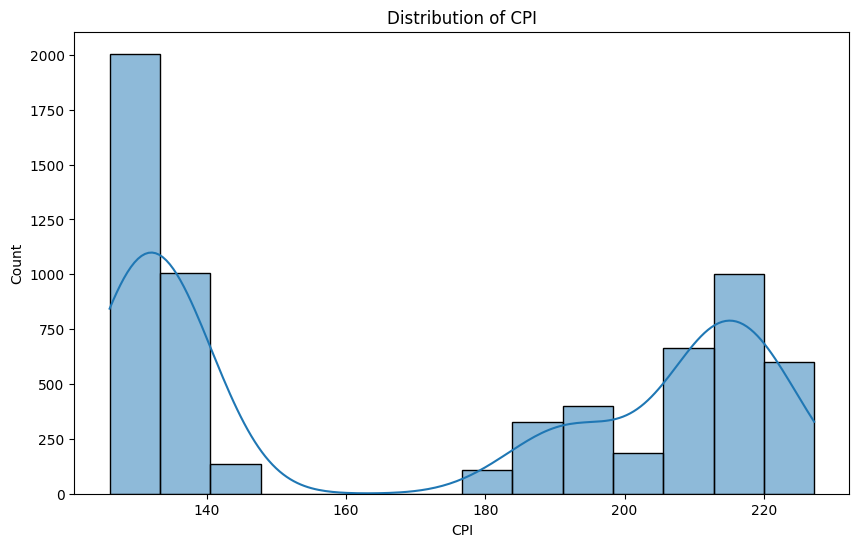

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(df['CPI'], kde=True)
plt.title('Distribution of CPI')
plt.show()

Al igual que anterior, observamos una distribución bimodal para el **_CPI_** con una mayor frecuencia en los valores mas bajos y una cola mas alargada y pequeña en los valores altos.

Se evidencia tambien un descenso en los valores entre 160 y 180

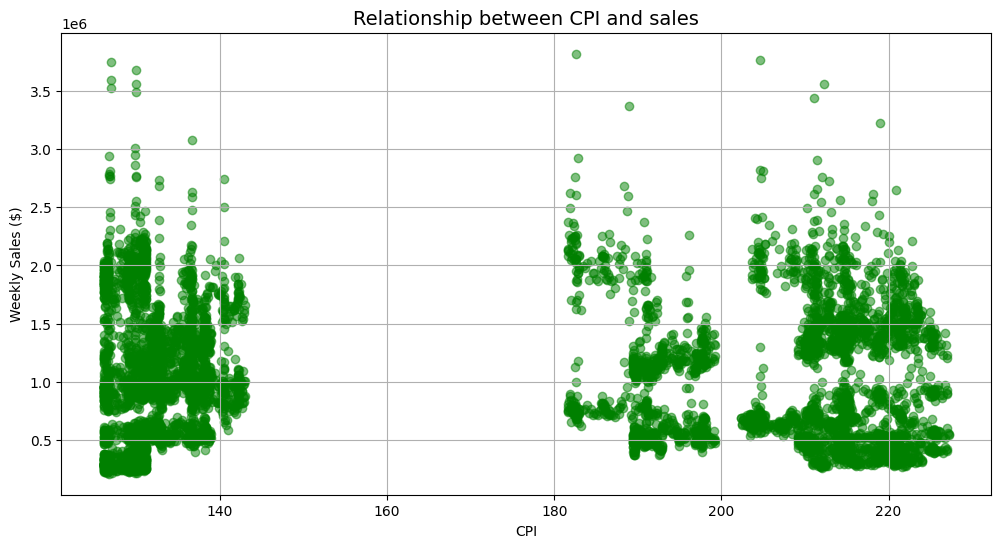

In [22]:
plt.figure(figsize=(12, 6))
plt.scatter(df['CPI'], df['Weekly_Sales'], alpha=0.5, color='green')
plt.title('Relationship between CPI and sales', fontsize=14)
plt.xlabel('CPI')
plt.ylabel('Weekly Sales ($)')
plt.grid(True)
plt.show()


Al igual que las demas variables no se evidencia correlación lineal con la variable ventas semanales.

### Unemployment

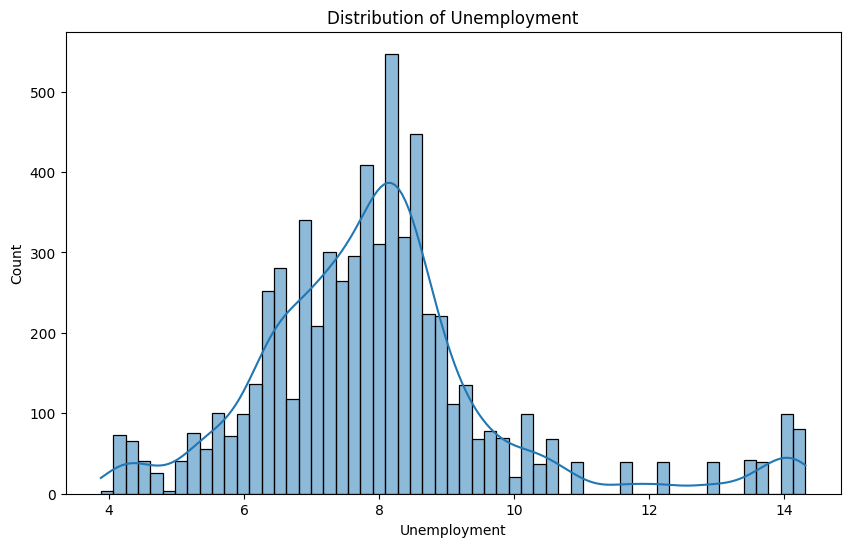

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Unemployment'], kde=True)
plt.title('Distribution of Unemployment')
plt.show()

Para el caso de **_Unemployment_** se evidencia una distribución mas parecida a una **_Gaussiana_** con una cola derecha mas pequeña y alargada.

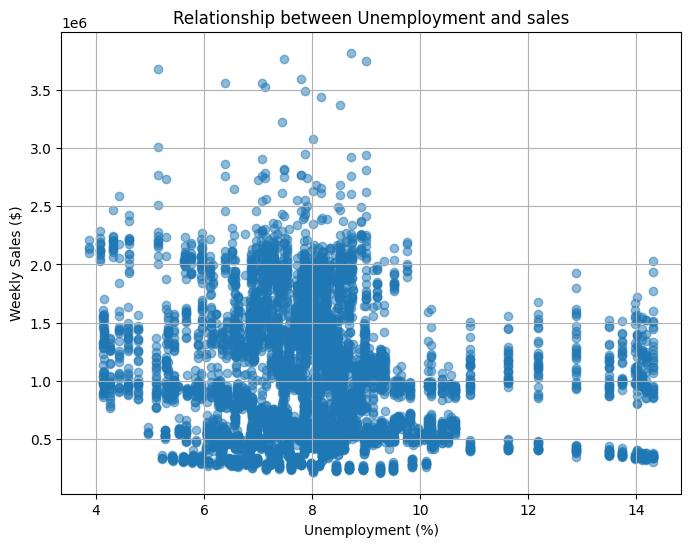

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Unemployment'], df['Weekly_Sales'], alpha=0.5)
plt.title('Relationship between Unemployment and sales')
plt.xlabel('Unemployment (%)')
plt.ylabel('Weekly Sales ($)')
plt.grid(True)
plt.show()

Aunque no se evidencia una relación clara, de entre todas, esta variable es la que mayor correlación parece tener con las ventas semanales.

## Correlación Lineal

Podemos graficar las correlaciones lineales entre las variables para validar la existencia de posibles colinealidades o multicolinealidades.

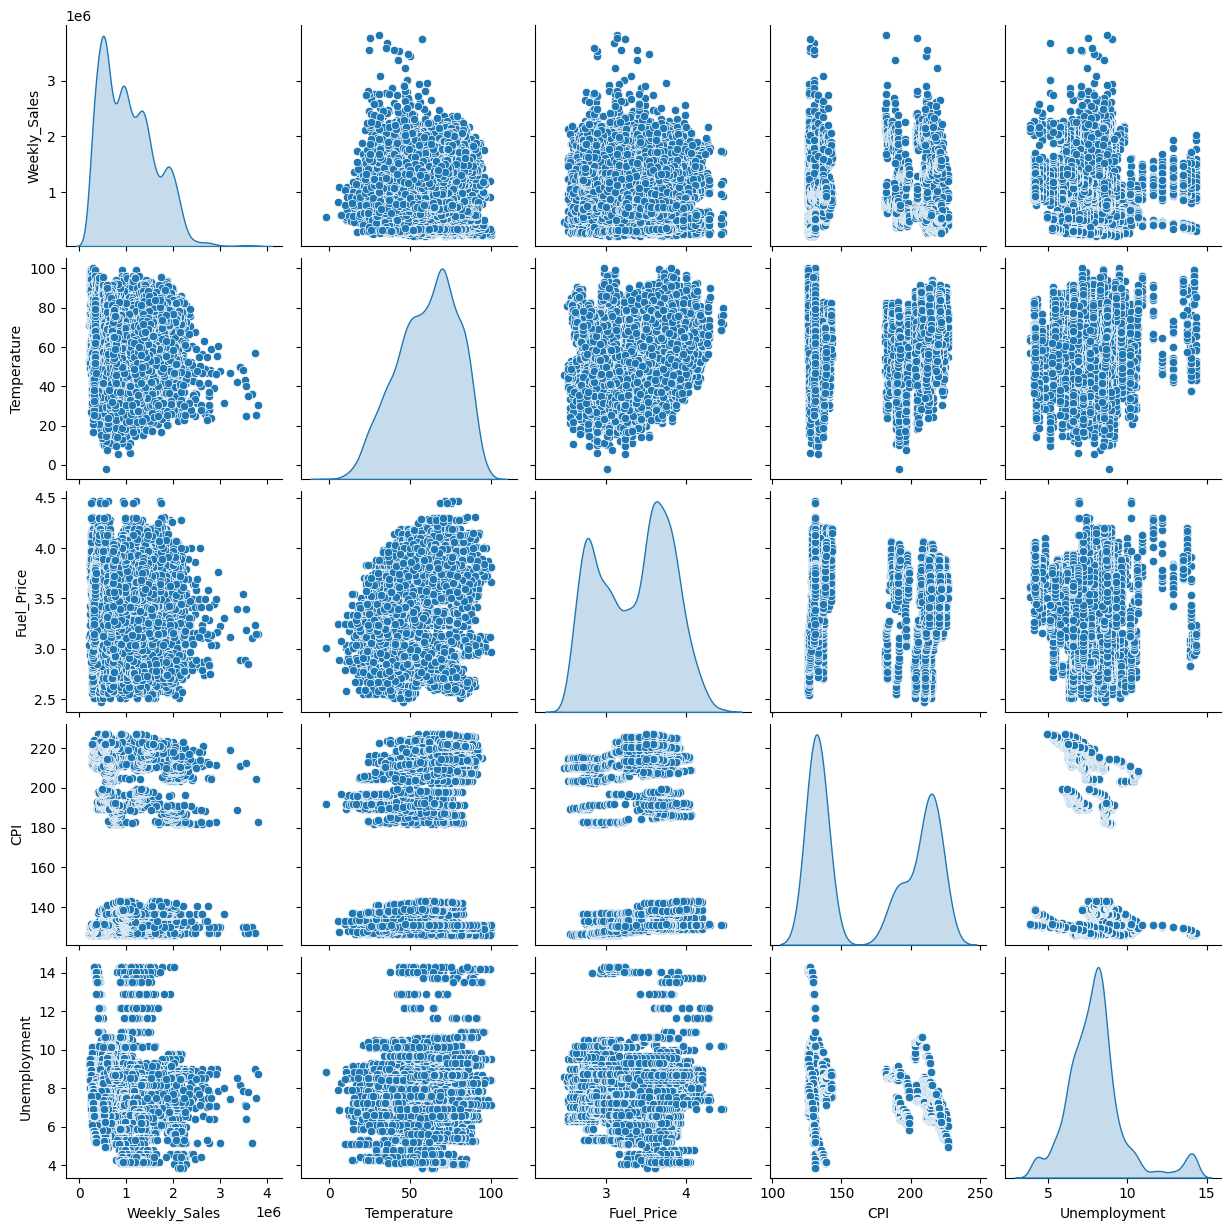

In [25]:
sns.pairplot(df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']], diag_kind='kde')
plt.show()


No se evidencia correlación lineal clara entre ningún par de variables. Las relaciones entre las ventas semanales y las demas variables son bajas, siendo la de mayor magnitud la correlación con **_Unemployment_** sugiriendo que a menor tasa de desempleo, las ventas tienden a subir.

Esto mismo lo podemos observar a traves de un **_Heat Map_** donde podemos visualizar la magnitud de estas correlaciones, las cuales todas son menor o igual a 0.3.

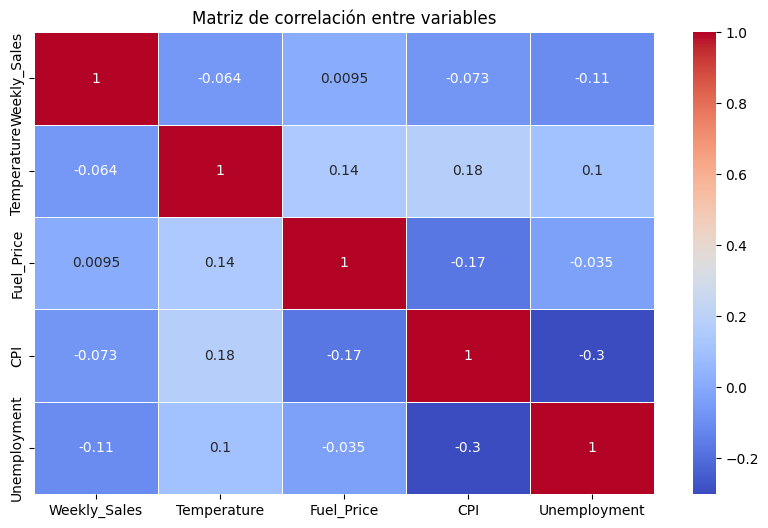

In [26]:
corr_matrix = df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación entre variables')
plt.show()

## Descomposicion de la serie

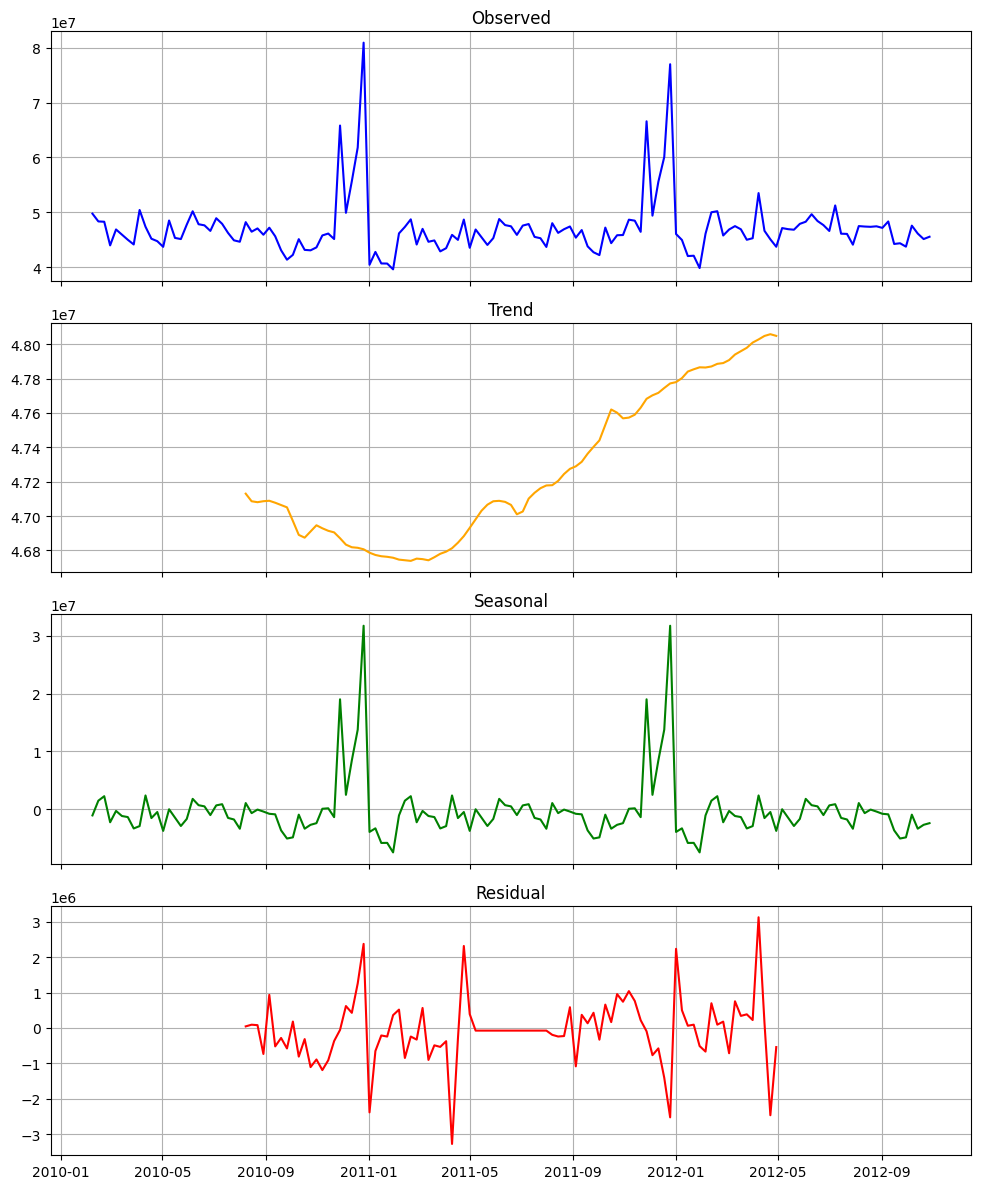

In [27]:
df.set_index('Date', inplace=True)
weekly_sales = df['Weekly_Sales'].resample('W').sum()

# Descomponer la serie temporal
decomposition = seasonal_decompose(weekly_sales, model='additive')

fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Observed
axes[0].plot(decomposition.observed.index, decomposition.observed, label='Observed', color='blue')
axes[0].set_title('Observed')
axes[0].grid(True)

# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend, label='Trend', color='orange')
axes[1].set_title('Trend')
axes[1].grid(True)

# Seasonal
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal, label='Seasonal', color='green')
axes[2].set_title('Seasonal')
axes[2].grid(True)

# Residual
axes[3].plot(decomposition.resid.index, decomposition.resid, label='Residual', color='red')
axes[3].set_title('Residual')
axes[3].grid(True)

plt.tight_layout()
plt.show()

Al descomponer la serie obtenemos los 4 componentes que se analizan a continuación:

* **_Observed_**: Este gráfico representa los datos en bruto tal y como fueron tomados y registrados, lo que mas resalta en este grafico son los picos que se presentan a finales de cada año, sugiriedonos la existencia de una posible estacionalidad. El resto del año las ventas presentan un comportamiento consistente.

* **_Trend_**: Este gráfico representa la tendencia real de la serie, una vez excluido las fluctuaciones estacionales y el ruido. Se evidencia una fluctuación entre los 4,68 y 4,80 millones con un descenso en las ventas en el periodo de finales del 2010 y comienzos de 2011, seguido de un aumento constante hasta mediados de 2012. 
El gráfico marca una tendencia creciente independiente de los posibles efectos de estacionalidades o ciclos.

* **_Seasonal_**: Este gráfico representa el componente estacional presente en la serie, se evidencia un patrón consistente entre los años 2011 y 2012 (mas concretamente a finales de los mismos), sugiriendo la existencia de una estacionalidad que como ya se mencionó antes muy seguramente se deba a un aumento en las ventas por temas de festividades como el día de acción de gracias y la navidad.

* **_Residual_**: Este gráfico representa lo queda luego de excluir la tendencia y la estacionalidad de los datos originales, esto es: fluctuaciones aleatorias o irregulares que no logran ser explicadas por los componentes antes mencionados. Para este caso no se observa ninguna tendencia marcada en el gráfico, sugiriendo que la descomposición ha capturado correctamente los componentes de la serie temporal.



Finalmente podemos validar si la serie es estacionaria a tráves de la prueba [Augmented Dickey-Fuller](https://es.statisticseasily.com/glosario/¿Qué-es-la-prueba-completa-de-Dickey-aumentada%3F/) que evalúa la siguiente hipótesis:

$$
Ho: \text{La serie tiene una raíz unitaria (no es estacionaria)}\\
H1: \text{La serie no tiene raíz unitaria (es estacionaria)}
$$

In [28]:
result = adfuller(weekly_sales)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.90829795718633
p-value: 2.6759791589860825e-07


Con un valor del estadístico de -5.908 y un valor p menor a $\alpha = 0.05$ se concluye que la serie es estacionaria